# Conditional-Like Execution and Masking

This section shows you how DALI arithmetic expressions can be used to achieve conditional-like application of augmentations and be used for some of the masking operations.

**Note**: DALI supports conditional execution allowing to run operations conditionally on selected samples using ``if`` statements. You can read more about it in the [conditional execution section](../../../pipeline.html#conditional-execution) of the Pipeline documentation. Using proper conditional execution is both more performant and memory effective. 

This example uses less efficient approach to show what is possible to achieve using DALI arithmetic expressions.

## Conditional Results

1. Create a pipeline that will use DALI arithmetic expressions to conditionally augment images.

2. We will emulate the conditional execution using [multiplexing](https://en.wikipedia.org/wiki/Multiplexer).

   For example, all transforms are applied to all inputs, but only the result of one of them is propagated to the output and others are rejected based on some condition.

**Note**: All possible inputs to our multiplexing operation will still be calculated by DALI as oposed to using the conditional execution.

### Imports

Here are the necessary imports.

In [1]:
from nvidia.dali import pipeline_def
import nvidia.dali.ops as ops
import nvidia.dali.fn as fn
import nvidia.dali.types as types
from nvidia.dali.types import Constant

### Explicitly Used Operators

 - The pipeline will use `readers.file` to provide the input images. We also need the `decoders.image` to decode the loaded images.

 - We will use `coin_flip` as a source for the random conditions and cast the result to bool, so it will work with the type promotion rules.

 - As an example augmentation, we will apply the `brightness_contrast` operator. The select parameters are extreme, so it will clearly show in the output.

### Graph with Custom Augmentation

1. Start with typical load and decode approach.

2. Apply the augmentation and keep the handles to both tensors, not augmented `imgs` and augmented `imgs_adjusted`.

3. Cast the `condition`, output of `coin_flip`, to bool.

## The Multiplexing Operation

1. Calculate the output `out` that is an equivalent to the following:

```
for idx in range(batch_size):
    if condition[idx]:
        out[idx] = imgs_adjusted[idx]
    else:
        out[idx] = imgs[idx]
        
```

2. Transform the condition to an arithmetic expression:
```
out = condition * imgs_adjusted + (not condition) * imgs
```
 - When the condition is `True` we multiply the `imgs_adjusted` by the `True` value (thus keeping it).
 
 - When it is `False` the multiplication yields `0`.
 
 - Multiplying some numerical type by `boolean` keeps the numerical type.
 
   To implement the `else` branch, we need to negate the `condition` and perform a similar multiplication operation, and add them together.

As the result of to Python operator limitations, negating the boolean condition is implemented as a bitwise `xor` operation with boolean constant `True`.

3. To visualize the results, we return the output of the multiplexing operation, the original images, and `coin_flip` values.

### Multiplexing as a Helper Function

To clean things up, we can wrap the multiplexing operation in the `mux` helper function.

**Note**: The inputs to `mux` need to allow for the specified element-wise expression. In our case, the condition is a batch of tensors that represent scalars, and that the corresponding elements of the `True` and `False` cases have matching shapes.

In [2]:
def mux(condition, true_case, false_case):
    neg_condition = condition ^ True
    return condition * true_case + neg_condition * false_case

@pipeline_def(batch_size=5, num_threads=1, device_id=0)
def mux_pipe():
    input_buf, _ = fn.readers.file(
        device="cpu", file_root="../../data/images", file_list="../../data/images/file_list.txt")
    imgs = fn.decoders.image(input_buf, device="cpu", output_type=types.RGB)
    imgs_adjusted = fn.brightness_contrast(imgs, brightness=3, contrast=1.5)
    condition = fn.random.coin_flip(dtype=types.DALIDataType.BOOL, seed=16)
    out = mux(condition, imgs_adjusted, imgs)

    return out, imgs, condition

### Running the Pipeline

1. Create an instance of the pipeline and build it. 

   A `batch_size = 5` was used, so we can observe that some of the output images are augmented and some are not.

In [3]:
pipe = mux_pipe()
pipe.build()

2. We will use a simple helper function to show the images.

   It takes the three outputs from the pipeline, the output of multiplexing is placed in left column, and the original images in the right, and it assigns proper captions.

In [4]:
import matplotlib.pyplot as plt
import numpy as np

def display(augmented, reference, flip_value = None, cpu = True):
    data_idx = 0
    fig, axes = plt.subplots(len(augmented), 2, figsize=(15, 15))
    for i in range(len(augmented)):
        img = augmented.at(i) if cpu else augmented.as_cpu().at(i)
        ref = reference.at(i) if cpu else reference.as_cpu().at(i)
        if flip_value:
            val = flip_value.at(i) if cpu else flip_value.as_cpu().at(i)
        else:
            val = True
        axes[i, 0].imshow(np.squeeze(img))
        axes[i, 1].imshow(np.squeeze(ref))
        axes[i, 0].axis('off')
        axes[i, 1].axis('off')
        axes[i, 0].set_title("Image was augmented" if val else "Image was not augmented")
        axes[i, 1].set_title("Original image")

3. Run and display the results.
   
   You can play this cell several times to see the result for different images.

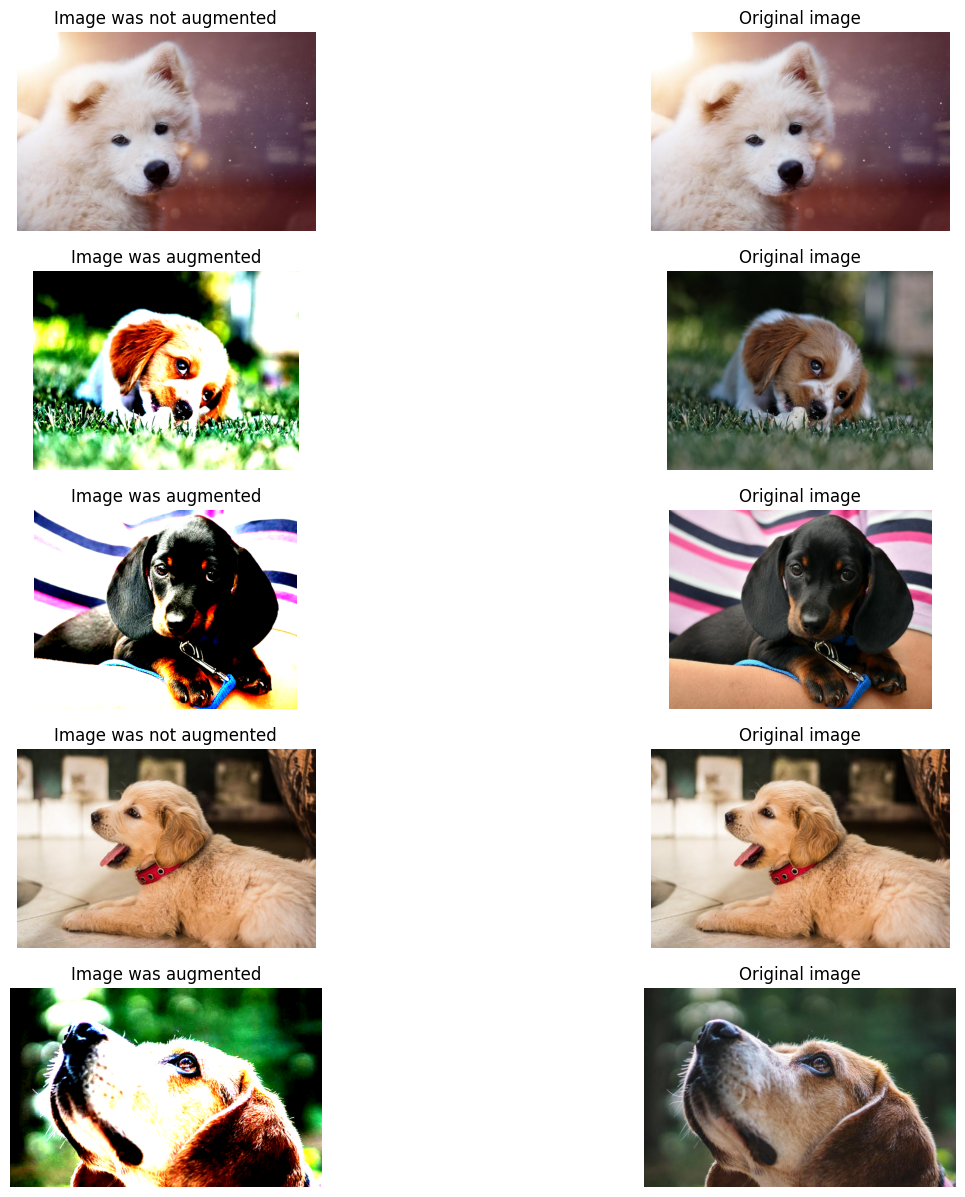

In [5]:
output, reference, flip_val = pipe.run()
display(output, reference, flip_val)

## Equivalent pipeline with conditional execution

The efficient way of implementing an equivalent pipeline would be to use conditional exution. 
We can rewrite the previous example using ``if`` statement to see the equivalent results while computing only the necessary data.

We need to specify ``enable_conditionals=True`` in the decorator for this feature to work.

In [6]:
@pipeline_def(batch_size=5, num_threads=1, device_id=0, enable_conditionals=True)
def conditional_pipe():
    input_buf, _ = fn.readers.file(
        device="cpu", file_root="../../data/images", file_list="../../data/images/file_list.txt")
    imgs = fn.decoders.image(input_buf, device="cpu", output_type=types.RGB)
    condition = fn.random.coin_flip(dtype=types.DALIDataType.BOOL, seed=16)
    if condition:
        out = fn.brightness_contrast(imgs, brightness=3, contrast=1.5)
    else:
        out = imgs

    return out, imgs, condition

Now we can run the other pipeline and see that the results are the same.

In [7]:
cond_pipe = conditional_pipe()
cond_pipe.build()

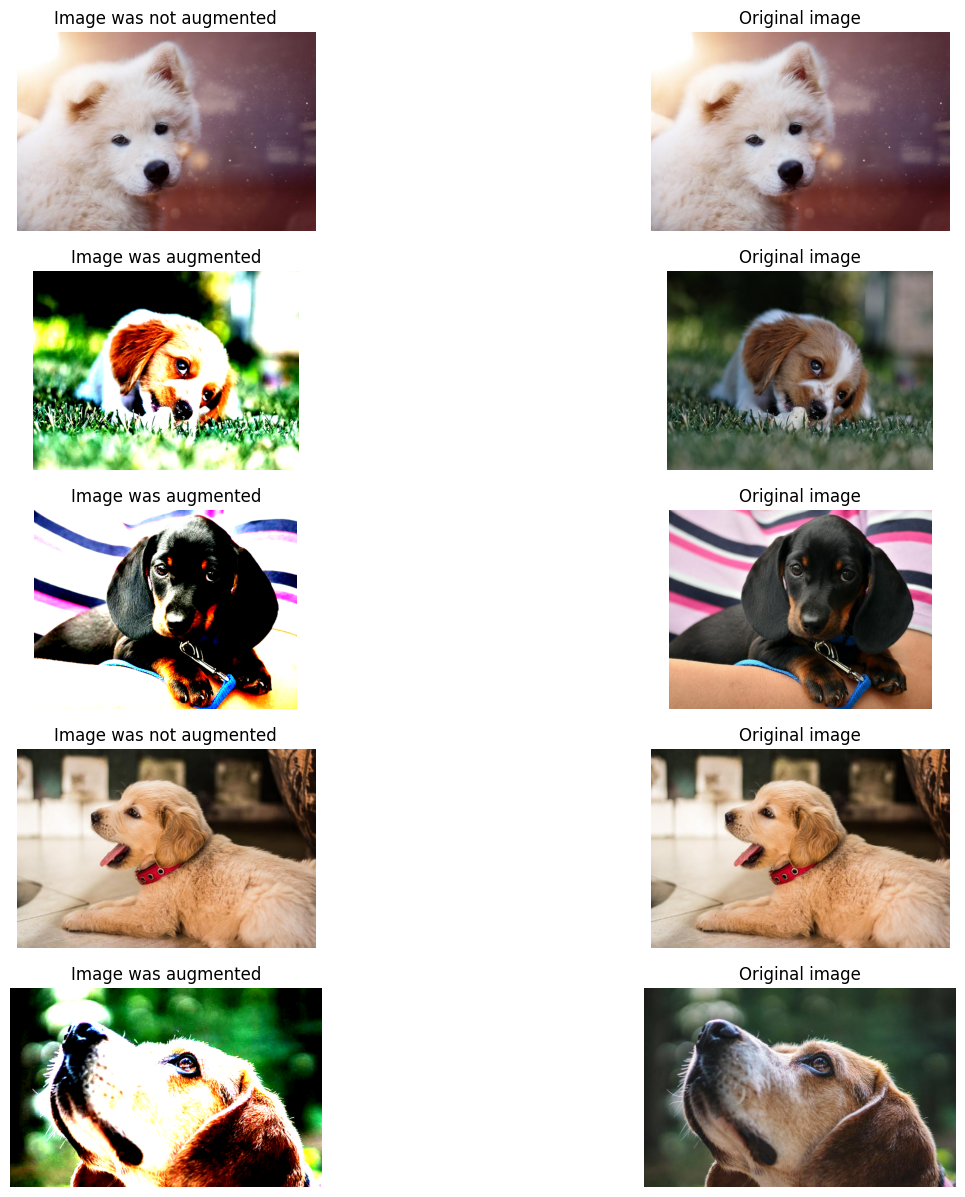

In [8]:
output, reference, flip_val = cond_pipe.run()
display(output, reference, flip_val)

## Generating Masks with Comparisons and Bitwise Operations

We can extend the pipeline by using some more complex logical conditions. We will use comparison operators to build masks that represent regions where the image has low and high pixel intensities.

We will use bitwise `OR` operation to build a mask that represents the union of this regions. The values in the mask are boolean, so the bitwise `|`, `&` `^` operations can be used like their logical counterparts.

DALI arithmetic expressions are elementwise and specific channel values can vary. We will calculate the masks on gray images, so we will get one value per pixel and duplicate the information to a 3-channel mask, by using the `Cat` operator, to ensure that the shape of image and mask match. We need the `ColorSpaceConversion` operator to handle RGB->Gray conversion.

We will apply brightening and darkening to specified regions by using the similar approach as before with multiplexing.

## Comparison Operators

DALI allows you to directly use all Python comparison operators. The tensors that will be obtained from comparison contain boolean values.

Creating 1-channel masks for low and high intensities is the same as writing `imgs_gray < 30` and `imgs_gray > 230`.

In [9]:
def not_(mask):
    return True ^ mask


def expand_mask(mask):
    return fn.cat(mask, mask, mask, axis=2)


@pipeline_def(batch_size=5, num_threads=1, device_id=0)
def masking_pipe():
    input_buf, _ = fn.readers.file(
        device="cpu", file_root="../../data/images", file_list="../../data/images/file_list.txt")
    imgs = fn.decoders.image(input_buf, device="cpu", output_type=types.RGB)

    imgs_gray = fn.color_space_conversion(imgs, image_type=types.RGB, output_type=types.GRAY)
    imgs_bright = fn.brightness_contrast(imgs, brightness=3)
    imgs_dark = fn.brightness_contrast(imgs, brightness=0.75)

    mask_low = expand_mask(imgs_gray < 30)
    mask_high = expand_mask(imgs_gray > 230)
    mask_other = not_(mask_low | mask_high)

    out = mask_low * imgs_bright + mask_high * imgs_dark + mask_other * imgs

    return out, imgs, mask_other * Constant(255).uint8()

In [10]:
mask_pipe = masking_pipe()
mask_pipe.build()

We will adjust our display function so in addition to original and augmented images we can also see the masks that we obtained.

In [11]:
def display2(augmented, reference, mask, cpu = True):
    data_idx = 0
    fig, axes = plt.subplots(len(augmented), 3, figsize=(15, 15))
    for i in range(len(augmented)):
        img = augmented.at(i) if cpu else augmented.as_cpu().at(i)
        ref = reference.at(i) if cpu else reference.as_cpu().at(i)
        m = mask.at(i) if cpu else mask.as_cpu().at(i)
        axes[i, 0].imshow(np.squeeze(img))
        axes[i, 1].imshow(np.squeeze(ref))
        axes[i, 2].imshow(np.squeeze(m))
        axes[i, 0].axis('off')
        axes[i, 1].axis('off')
        axes[i, 2].axis('off')
        axes[i, 0].set_title("Augmented image")
        axes[i, 1].set_title("Reference decoded image")
        axes[i, 2].set_title("Calculated mask")

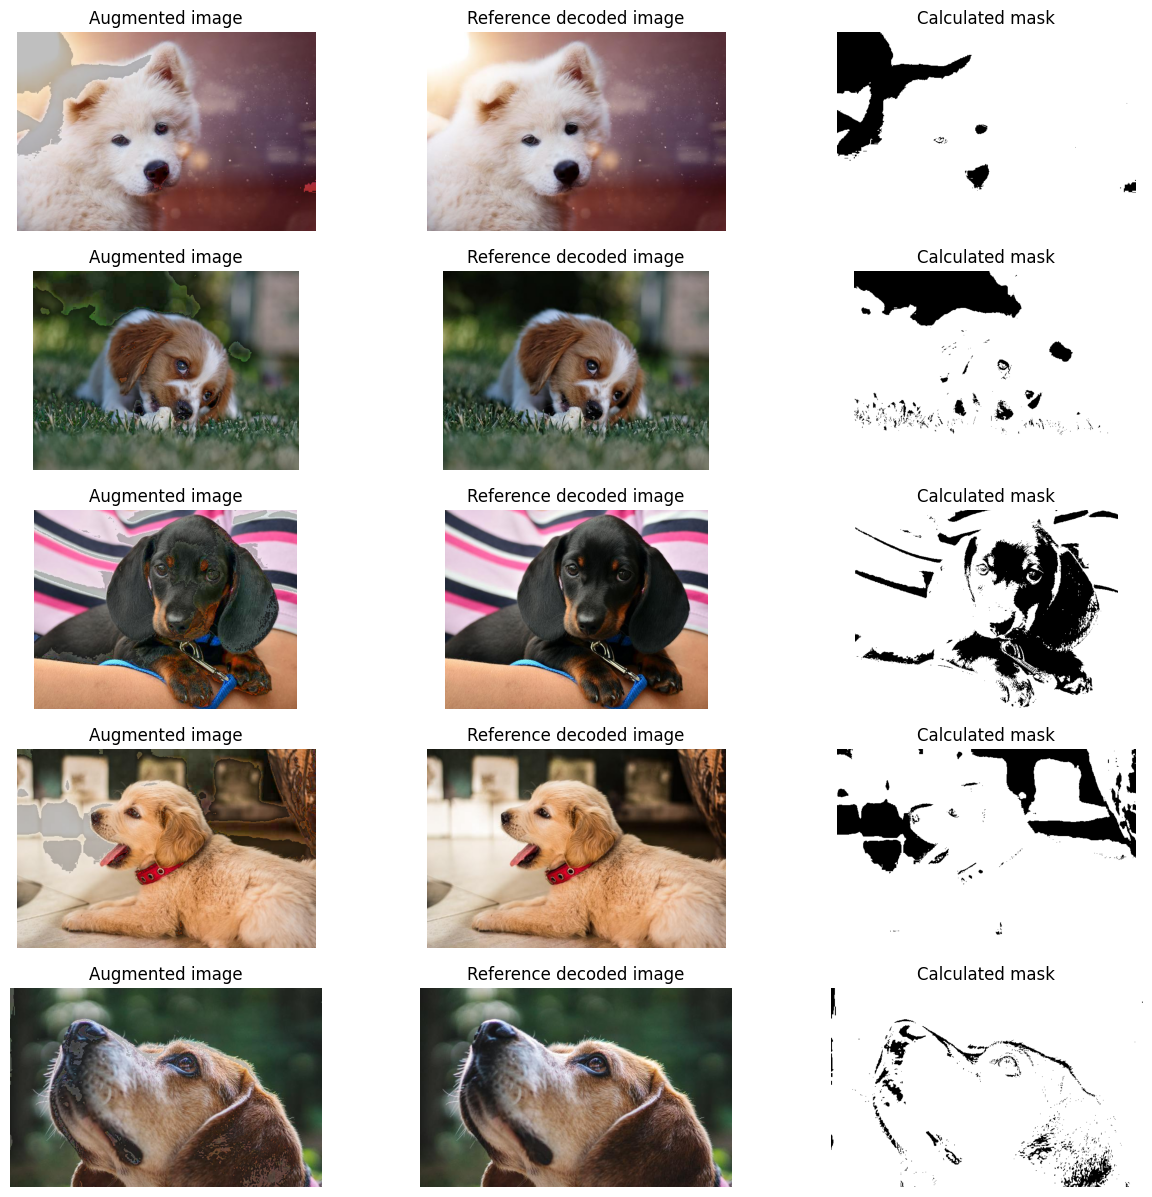

In [12]:
output, reference, mask = mask_pipe.run()
display2(output, reference, mask)